In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim.lr_scheduler
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
import gensim 
import gensim.downloader as api
from gensim.models import Word2Vec  
#from torchnlp.word_to_vector import GloVe, FastText
import torchtext.data as ttd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from nltk.stem.porter import PorterStemmer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
#from warnings import simplefilter
#simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
folder=Path('/content/gdrive/My Drive/NLP')

**Text pre-processing**

In [70]:
df = pd.read_csv(folder / 'train1.csv', encoding='ISO-8859-1')
#print(df.columns)

#df.describe()

df_test1 = pd.read_csv(folder / 'test1.csv', encoding='ISO-8859-1')
#print(df.columns)

#df_test1.describe()

In [71]:
df.head()

,id,text,target
0,86426,@USER She should ask a few native Americans wh...,1
1,16820,Amazon is investigating Chinese employees who ...,0
2,62688,"@USER Someone should'veTaken"" this piece of sh...",1
3,43605,@USER @USER Obama wanted liberals &amp; illega...,0
4,97670,@USER Liberals are all Kookoo !!!,1


In [72]:
df_test1.head()

,id,text
0,90194,@USER @USER Go home youâre drunk!!! @USER #M...
1,77444,@USER @USER Oh noes! Tough shit.
2,13384,@USER Canada doesnât need another CUCK! We a...
3,54920,@USER @USER @USER It should scare every Americ...
4,56117,@USER @USER @USER @USER LOL!!! Throwing the ...


In [73]:
# drop unnecessary columns
df = df.drop(["id"], axis=1)

In [74]:
df.head()

,text,target
0,@USER She should ask a few native Americans wh...,1
1,Amazon is investigating Chinese employees who ...,0
2,"@USER Someone should'veTaken"" this piece of sh...",1
3,@USER @USER Obama wanted liberals &amp; illega...,0
4,@USER Liberals are all Kookoo !!!,1


In [75]:
#pre-processing
#=================
df["text"]=df["text"].str.lower()  #convert to lower case
df["text"]=df["text"].str.replace('\d+','') # remove numbers
df["text"]=df["text"].str.replace('<.*?>','') # remove HTML tags
df["text"]=df["text"].str.replace('[^@\w\s]','') # remove punctuation  

#print(df)

df_test1["text"]=df_test1["text"].str.lower()  #convert to lower case
df_test1["text"]=df_test1["text"].str.replace('\d+','') # remove numbers
df_test1["text"]=df_test1["text"].str.replace('<.*?>','') # remove HTML tags
df_test1["text"]=df_test1["text"].str.replace('[^@\w\s]','') # remove punctuation  

#print(df)


In [11]:
# stemming
#===========
st = SnowballStemmer('english')
df['text'] =df['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
print(df)

df_test1['text'] =df_test1['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
print(df_test1)

                                                   text  target
0     @user she should ask a few nativ american what...       1
1     amazon is investig chines employe who are sell...       0
2     @user someon shouldvetaken this piec of shit t...       1
3     @user @user obama want liber amp illeg to move...       0
4                            @user liber are all kookoo       1
...                                                 ...     ...
9341                        @user @user but gun control       0
9342  @user ðððððð if i say you are mad now you will...       0
9343  @user @user @user @user @user @user @user @use...       0
9344  @user and whi report this garbag we dont give ...       1
9345                                        @user pussi       1

[9346 rows x 2 columns]
         id                                               text
0     90194  @user @user go home youâr drunk @user maga tru...
1     77444                      @user @user oh noe tough shit
2     13384  @user

In [76]:
# remove stopwords
#====================

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print(df)

df_test1['text'] = df_test1['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print(df_test1)

                                                   text  target
0                       @user ask native americans take       1
1     amazon investigating chinese employees selling...       0
2      @user someone shouldvetaken piece shit volcano ð       1
3     @user @user obama wanted liberals amp illegals...       0
4                                 @user liberals kookoo       1
...                                                 ...     ...
9341                            @user @user gun control       0
9342                  @user ðððððð say mad say im tired       0
9343  @user @user @user @user @user @user @user @use...       0
9344                @user report garbage dont give crap       1
9345                                        @user pussy       1

[9346 rows x 2 columns]
         id                                               text
0     90194  @user @user go home youâre drunk @user maga tr...
1     77444                     @user @user oh noes tough shit
2     13384  @user

In [77]:
#word tokenizer
#===============
# using tweetokenizer to remove @ handles. WordPunctTokenizer does not keep handles together.

tknzr = TweetTokenizer(strip_handles=True)
df['text']=df['text'].apply(lambda row: " ".join(tknzr.tokenize(row)))
print(df)

df_test1['text']=df_test1['text'].apply(lambda row: " ".join(tknzr.tokenize(row)))
print(df_test1)

                                                   text  target
0                             ask native americans take       1
1     amazon investigating chinese employees selling...       0
2            someone shouldvetaken piece shit volcano ð       1
3     obama wanted liberals amp illegals move red st...       0
4                                       liberals kookoo       1
...                                                 ...     ...
9341                                        gun control       0
9342                           ððð say mad say im tired       0
9343   retweet complete amp followed patriotsðºððªïðââï       0
9344                      report garbage dont give crap       1
9345                                              pussy       1

[9346 rows x 2 columns]
         id                                               text
0     90194          go home youâre drunk maga trump ððºðð url
1     77444                                 oh noes tough shit
2     13384  canad

In [78]:
df['text']=df['text'].str.replace('[^A-Za-z0-9\s]','') # remove special characters 
df_test1["text"]=df_test1["text"].str.replace('[^A-Za-z0-9\s]','') # remove special characters 

print(df)
print(df_test1)

                                                   text  target
0                             ask native americans take       1
1     amazon investigating chinese employees selling...       0
2             someone shouldvetaken piece shit volcano        1
3     obama wanted liberals amp illegals move red st...       0
4                                       liberals kookoo       1
...                                                 ...     ...
9341                                        gun control       0
9342                               say mad say im tired       0
9343             retweet complete amp followed patriots       0
9344                      report garbage dont give crap       1
9345                                              pussy       1

[9346 rows x 2 columns]
         id                                               text
0     90194                go home youre drunk maga trump  url
1     77444                                 oh noes tough shit
2     13384  canad

In [79]:
df['target'].value_counts()

0    6220
1    3126
Name: target, dtype: int64

In [80]:
df.columns = ['data', 'labels']
df.head()

,data,labels
0,ask native americans take,1
1,amazon investigating chinese employees selling...,0
2,someone shouldvetaken piece shit volcano,1
3,obama wanted liberals amp illegals move red st...,0
4,liberals kookoo,1


In [81]:
df_test1.columns = ['id', 'data']
df_test2 = df_test1.copy()

df_test2 = df_test2.drop(["id"], axis=1)
df_test2.head()

# adding a dummy column of labels = all are set to 1
df_test2['labels']=1

In [82]:
df.to_csv(folder / 'train2.csv', index=False)

In [83]:
df_test2.to_csv(folder / 'test2.csv', index=False)

In [84]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    tokenize='spacy',
    pad_first=True)

LABEL = ttd.LabelField()
#LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

dataset = ttd.TabularDataset(
    path= folder / 'train2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

dataset_test1 = ttd.TabularDataset(
    path= folder / 'test2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [85]:
import random
SEED=777
train_dataset, test_dataset = dataset.split(split_ratio=0.7,random_state = random.seed(SEED)) # default is 0.7

In [86]:
SEED=777
train_dataset, valid_dataset = train_dataset.split(random_state = random.seed(SEED)) # default is 0.7

In [87]:
SEED=777
test_1, test_2 = dataset_test1.split(split_ratio=0.9998, random_state = random.seed(SEED)) # default is 0.7

In [88]:
print(f'Number of training examples: {len(test_1)}')
print(f'Number of validation examples: {len(test_2)}')

Number of training examples: 3893
Number of validation examples: 1


In [89]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 4579
Number of validation examples: 1963
Number of testing examples: 2804


In [90]:
print(f'Number of actual testing examples: {len(test_1)}')

Number of actual testing examples: 3893


In [92]:
#Using Pretrained Embeddings
#============================

MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [93]:
LABEL.build_vocab(train_dataset)
vocab_text = TEXT.vocab
vocab_text.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<unk>': 0,
             '<pad>': 1,
             'nt': 2,
             'url': 3,
             'liberals': 4,
             'gun': 5,
             'control': 6,
             'antifa': 7,
             'like': 8,
             'maga': 9,
             's': 10,
             'do': 11,
             'people': 12,
             'conservatives': 13,
             'trump': 14,
             ' ': 15,
             'i': 16,
             'one': 17,
             'know': 18,
             'get': 19,
             'would': 20,
             'amp': 21,
             'think': 22,
             'm': 23,
             'right': 24,
             'good': 25,
             'that': 26,
             'us': 27,
             'shit': 28,
             're': 29,
             'never': 30,
             'going': 31,
             'want': 32,
             'time': 33,
             'really': 34,
             'see': 35,
             'go': 36,
             'need': 37,

In [94]:
vocab_text.itos

['<unk>',
 '<pad>',
 'nt',
 'url',
 'liberals',
 'gun',
 'control',
 'antifa',
 'like',
 'maga',
 's',
 'do',
 'people',
 'conservatives',
 'trump',
 ' ',
 'i',
 'one',
 'know',
 'get',
 'would',
 'amp',
 'think',
 'm',
 'right',
 'good',
 'that',
 'us',
 'shit',
 're',
 'never',
 'going',
 'want',
 'time',
 'really',
 'see',
 'go',
 'need',
 'love',
 'even',
 'you',
 'say',
 'ca',
 'vote',
 'way',
 'its',
 'back',
 'make',
 'left',
 'well',
 'much',
 'still',
 'party',
 'he',
 'president',
 'take',
 'look',
 'democrats',
 'country',
 'stop',
 'could',
 'man',
 'years',
 'does',
 'great',
 'nothing',
 'also',
 'better',
 'keep',
 'lol',
 'many',
 'believe',
 'another',
 'did',
 'said',
 'u',
 'hope',
 'thing',
 'white',
 'away',
 'everyone',
 'liberal',
 've',
 'america',
 'they',
 'care',
 'god',
 'trying',
 'women',
 'kavanaugh',
 'yes',
 'call',
 'got',
 'is',
 'life',
 'guns',
 'new',
 'work',
 'every',
 'support',
 'ever',
 'laws',
 'money',
 'fuck',
 'getting',
 'since',
 'sure',

In [95]:
len(vocab_text)

10902

In [96]:
vocab_label = LABEL.vocab
vocab_label.stoi

defaultdict(<function torchtext.vocab._default_unk_index>, {'0': 0, '1': 1})

In [97]:
vocab_label.itos

['0', '1']

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [99]:
train_iter, valid_iter, test_iter = ttd.BucketIterator.splits((train_dataset,valid_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(32,128,128),
                              device=device)

In [100]:
dataset_test_iter = ttd.BucketIterator(test_1, 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_size=128,
                              device='cuda:0')

In [101]:
for batch in dataset_test_iter:
  print("inputs:", batch.data, batch.data.shape)
  #print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[   1,    1,    1,  ...,    0,  209, 2570],
        [   1,    1,    1,  ...,    0,  401,    9],
        [   1,    1,    1,  ...,    1,  121,  526],
        ...,
        [   1,    1,    1,  ...,    2,   32,    0],
        [   1,    1,    1,  ...,  428,  350,  297],
        [   1,    1,    1,  ...,   12,  386,   69]], device='cuda:0') torch.Size([128, 33])


In [102]:
for batch in train_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  1488,  1332,  9580,   185,
           172],
        [    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,   213,    91,   292,
           228,    11,     2,    18,    32,  7258,  3132,     9,  3030, 10334,
             3],
        [    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  4256,    11,     2,   121,
             4],
        [    1,     1,     1,     1,     1,     1,     1,     1,     1,   473,
          1689,    35,   933,  1344,    12,     8,  1051,    57,   128,   181,
          9302,   761,  2779,  2316,   476,   445,     8,    49,    35, 

In [103]:
for batch in valid_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[  778,  5409],
        [  257,  1318],
        [   34,  8784],
        [  216,  2011],
        [  488,    75],
        [   44,   149],
        [   36,    79],
        [  235,     0],
        [ 1764,     0],
        [    0,  1028],
        [    7,  6650],
        [   18,     0],
        [  882, 10421],
        [  710,   782],
        [ 1003,  2995],
        [    0,  9254],
        [  192,   137],
        [ 2590,  2901],
        [  193,   143],
        [ 3560,    22],
        [ 1095,     4],
        [ 6718,   170],
        [ 1025,     3],
        [ 5022,   244],
        [   90,     3],
        [   15,  3150],
        [   86,   618],
        [ 1306,     0],
        [ 1355,   287],
        [    0,   107],
        [  103,  1165],
        [  138,    28],
        [  535,    28],
        [ 5490,     0],
        [  532,    25],
        [ 6889,  2077],
        [   38, 10020],
        [    1,    38],
        [    1,   192],
        [    1,   593],
        [    1,   509],
        

In [104]:
for batch in test_iter:
  print("inputs:", batch.data[0], batch.data[0].shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([5692, 4177], device='cuda:0') torch.Size([2])
targets: tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') shape: torch.Size([128])


**Vanilla RNN**

In [105]:
#Vanilla RNN class
#==================

class SimpleRNN(nn.Module):
  def __init__(self, n_vocab, n_embed_dim, n_hidden, n_rnnlayers, n_outputs, dropout_rate):
    super(SimpleRNN, self).__init__()
    self.D = n_embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers
    self.V = n_vocab
    self.dropout_rate=dropout_rate

    # embedding layer
    self.embed = nn.Embedding(self.V, self.D)

    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    
    self.fc = nn.Linear(self.M, self.K)
    
    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    # X (batch_size, sentence length)
    embedding = self.embed(X)   # (batch_size, sentence_length, emd_dim)
    embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

    # get RNN unit output
    out, _ = self.rnn(embedding, h0)
    #print(res.shape)

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    #out = self.fc(out)
    return out

In [106]:
# Make some data
N = len(TEXT.vocab)
T = 7
D = 100    
M = 150   
K = 2  
L = 1  #no.of RNN layers  
dropout_rate = 0.01  
X = np.random.randn(N, T, D)
print(X.shape)

# Notation
# N = number of samples
# T = sequence length
# D = embedding dimension
# M = number of hidden units
# K = number of output units

(10902, 7, 100)


In [107]:
# Instantiate the model
model = SimpleRNN(n_vocab=N, n_embed_dim=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, dropout_rate=dropout_rate)
model.to(device)

SimpleRNN(
  (embed): Embedding(10902, 100)
  (rnn): RNN(100, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [108]:
print(model)

SimpleRNN(
  (embed): Embedding(10902, 100)
  (rnn): RNN(100, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)


In [109]:
for name, param in model.named_parameters():
  print(name, param.shape)

embed.weight torch.Size([10902, 100])
rnn.weight_ih_l0 torch.Size([150, 100])
rnn.weight_hh_l0 torch.Size([150, 150])
rnn.bias_ih_l0 torch.Size([150])
rnn.bias_hh_l0 torch.Size([150])
fc.weight torch.Size([2, 150])
fc.bias torch.Size([2])


In [110]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([10902, 100])


In [111]:
model.embed.weight.data.copy_(pretrained_embeddings)   #Initializing weights with Pre-trained embeddings

tensor([[ 4.7293e-02,  2.4148e+00, -3.7467e-01,  ..., -5.6043e-01,
         -4.2474e-01, -6.4430e-01],
        [-2.1092e-03,  1.1528e+00, -6.3001e-01,  ..., -1.2343e+00,
          6.8661e-01, -2.0555e-01],
        [ 3.1810e-01,  1.0088e+00, -2.6260e-01,  ..., -1.6182e-02,
          1.8295e+00, -5.7388e-01],
        ...,
        [-2.7968e-01,  1.0566e+00,  3.9891e-01,  ..., -5.3530e-01,
          7.4959e-01,  1.0814e+00],
        [-1.2533e-01, -3.7238e-01, -5.5980e-02,  ...,  3.3211e-01,
         -4.0862e-01, -2.7781e-01],
        [-5.5559e-01, -1.7610e-02,  6.5311e-01,  ...,  2.4946e-01,
         -7.5647e-02,  6.6210e-02]], device='cuda:0')

In [112]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embed.weight.data[unk_idx] = torch.zeros(D)
model.embed.weight.data[pad_idx] = torch.zeros(D)

print(model.embed.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3181,  1.0088, -0.2626,  ..., -0.0162,  1.8295, -0.5739],
        ...,
        [-0.2797,  1.0566,  0.3989,  ..., -0.5353,  0.7496,  1.0814],
        [-0.1253, -0.3724, -0.0560,  ...,  0.3321, -0.4086, -0.2778],
        [-0.5556, -0.0176,  0.6531,  ...,  0.2495, -0.0756,  0.0662]],
       device='cuda:0')


**Train model**

In [113]:
learning_rate = 0.005
epochs=300

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [114]:

patience = 10
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0
path = folder / 'early_stop_nlp.pt'

# Freeze embedding Layer

#freeze embeddings
model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  scheduler.step()
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  
  for batch in train_iter:
    # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
 
      # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')


   ## Early Stopping
  ##==================
    
  score = -valid_loss
  print("Validation loss is {0} and score is {1} ".format(valid_loss, score))

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(), path)
      valid_loss_min = valid_loss
      
  elif score < best_score + delta:
      counter_early_stop += 1

      print("Inside elif: Score is {0}, Best score is {1} and delta is {2} ".format(score, best_score, delta))

      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      
      if counter_early_stop >= patience:
          early_stop = True
          # un-freeze embeddings - start updating weights when validation losses start to increase
          #========================================================================================
          model.embed.weight.requires_grad  = True

  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(), path)
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/300, Train Loss: 0.6139    Valid Loss: 0.5899, Duration: 0:00:00.576688
Validation loss is 0.5898895226418972 and score is -0.5898895226418972 
Validation loss decreased (inf --> 0.589890).  Saving model ...
Epoch 2/300, Train Loss: 0.6263    Valid Loss: 0.5962, Duration: 0:00:00.590661
Validation loss is 0.5962082464247942 and score is -0.5962082464247942 
Inside elif: Score is -0.5962082464247942, Best score is -0.5898895226418972 and delta is 0 
Early Stopping counter: 1 out of 10
Epoch 3/300, Train Loss: 0.5514    Valid Loss: 0.5969, Duration: 0:00:00.725441
Validation loss is 0.5968974735587835 and score is -0.5968974735587835 
Inside elif: Score is -0.5968974735587835, Best score is -0.5898895226418972 and delta is 0 
Early Stopping counter: 2 out of 10
Epoch 4/300, Train Loss: 0.5057    Valid Loss: 0.5565, Duration: 0:00:00.577882
Validation loss is 0.5564957298338413 and score is -0.5564957298338413 
Validation loss decreased (0.589890 --> 0.556496).  Saving model ...
E

In [115]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

In [116]:
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.8814,	 Valid acc: 0.7555,	 Test acc: 0.7222


In [117]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch.label.cpu().numpy())) 
      
  return y_test, predictions

In [118]:
y_test, predictions=get_predictions(test_iter, model)

In [119]:
predictions.max()

1.0

In [120]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[1523,  338],
       [ 441,  502]])

In [121]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

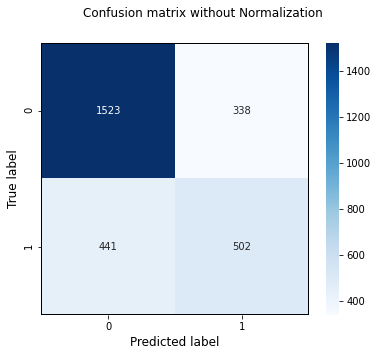

In [122]:
plot_confusion_matrix(y_test,predictions)

In [123]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

F2_Measure = (5 * precision * recall) / (4 * precision + recall)
F2_Measure

1.3551336681402562

**LSTM**

In [124]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers
    self.num_diections= bidirectional
    self.dropout_rate=dropout_rate
    
    # embedding layer
    self.embed = nn.Embedding(self.V, self.D)
    
    # rnn layers
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        bidirectional=self.num_diections,
        dropout= self.dropout_rate,
        batch_first=True)
    
    # dense layer
    if(bidirectional==True):
        self.fc = nn.Linear(self.M *2 , self.K)
    else:
        self.fc = nn.Linear(self.M , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):
    # initial hidden states
    if(bidirectional==True):
        h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
    else:  
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    # X (batch_size, sentence length)
    embedding = self.embed(X)   # (batch_size, sentence_length, emd_dim)
    embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

    # get RNN unit output
    output, (hidden,cell) = self.rnn(embedding, (h0, c0))


    #output = [batch size, sent len, hid dim * num directions]
    #hidden = [num layers * num directions, batch size, hid dim]
    #cell = [num layers * num directions, batch size, hid dim]

    # max pool
    output, _ = torch.max(output, 1)
    output= self.dropout(output)
    # we only want h(T) at the final time step
    output = self.fc(output)
    return output

In [125]:
n_vocab = len(TEXT.vocab)
embed_dim = 100
n_hidden = 150 
n_rnnlayers = 3
n_outputs = 2
bidirectional = False 
dropout_rate = 0.01 

In [126]:
model_LSTM = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate=dropout_rate)
model_LSTM.to(device)

RNN(
  (embed): Embedding(10902, 100)
  (rnn): LSTM(100, 150, num_layers=3, batch_first=True, dropout=0.01)
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [127]:
for name, param in model_LSTM.named_parameters():
  print(name, param.shape)

embed.weight torch.Size([10902, 100])
rnn.weight_ih_l0 torch.Size([600, 100])
rnn.weight_hh_l0 torch.Size([600, 150])
rnn.bias_ih_l0 torch.Size([600])
rnn.bias_hh_l0 torch.Size([600])
rnn.weight_ih_l1 torch.Size([600, 150])
rnn.weight_hh_l1 torch.Size([600, 150])
rnn.bias_ih_l1 torch.Size([600])
rnn.bias_hh_l1 torch.Size([600])
rnn.weight_ih_l2 torch.Size([600, 150])
rnn.weight_hh_l2 torch.Size([600, 150])
rnn.bias_ih_l2 torch.Size([600])
rnn.bias_hh_l2 torch.Size([600])
fc.weight torch.Size([2, 150])
fc.bias torch.Size([2])


In [128]:
model_LSTM.embed.weight.data.copy_(pretrained_embeddings)   #Initializing weights with Pre-trained embeddings

tensor([[ 4.7293e-02,  2.4148e+00, -3.7467e-01,  ..., -5.6043e-01,
         -4.2474e-01, -6.4430e-01],
        [-2.1092e-03,  1.1528e+00, -6.3001e-01,  ..., -1.2343e+00,
          6.8661e-01, -2.0555e-01],
        [ 3.1810e-01,  1.0088e+00, -2.6260e-01,  ..., -1.6182e-02,
          1.8295e+00, -5.7388e-01],
        ...,
        [-2.7968e-01,  1.0566e+00,  3.9891e-01,  ..., -5.3530e-01,
          7.4959e-01,  1.0814e+00],
        [-1.2533e-01, -3.7238e-01, -5.5980e-02,  ...,  3.3211e-01,
         -4.0862e-01, -2.7781e-01],
        [-5.5559e-01, -1.7610e-02,  6.5311e-01,  ...,  2.4946e-01,
         -7.5647e-02,  6.6210e-02]], device='cuda:0')

In [129]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model_LSTM.embed.weight.data[unk_idx] = torch.zeros(embed_dim)
model_LSTM.embed.weight.data[pad_idx] = torch.zeros(embed_dim)

print(model_LSTM.embed.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3181,  1.0088, -0.2626,  ..., -0.0162,  1.8295, -0.5739],
        ...,
        [-0.2797,  1.0566,  0.3989,  ..., -0.5353,  0.7496,  1.0814],
        [-0.1253, -0.3724, -0.0560,  ...,  0.3321, -0.4086, -0.2778],
        [-0.5556, -0.0176,  0.6531,  ...,  0.2495, -0.0756,  0.0662]],
       device='cuda:0')


**Train Model**

In [130]:
learning_rate = 0.005
epochs=300

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [131]:

patience = 10
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0
path = folder / 'early_stop_nlp.pt'

# Freeze embedding Layer

#freeze embeddings
model_LSTM.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  scheduler.step()
  t0= datetime.now()
  train_loss=[]
  
  model_LSTM.train()
  
  for batch in train_iter:
    # forward pass
    output= model_LSTM(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model_LSTM.eval()
  with torch.no_grad():
    for batch in valid_iter:
 
      # forward pass
      output= model_LSTM(batch.data)
      loss=criterion(output,batch.label)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')


   ## Early Stopping
  ##==================
    
  score = -valid_loss
  print("Validation loss is {0} and score is {1} ".format(valid_loss, score))

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_LSTM.state_dict(), path)
      valid_loss_min = valid_loss
      
  elif score < best_score + delta:
      counter_early_stop += 1

      print("Inside elif: Score is {0}, Best score is {1} and delta is {2} ".format(score, best_score, delta))

      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      
      if counter_early_stop >= patience:
          early_stop = True
          # un-freeze embeddings - start updating weights when validation losses start to increase
          #========================================================================================
          model_LSTM.embed.weight.requires_grad  = True

  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_LSTM.state_dict(), path)
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/300, Train Loss: 0.5937    Valid Loss: 0.5104, Duration: 0:00:01.340433
Validation loss is 0.5104416888207197 and score is -0.5104416888207197 
Validation loss decreased (inf --> 0.510442).  Saving model ...
Epoch 2/300, Train Loss: 0.4958    Valid Loss: 0.5369, Duration: 0:00:01.310820
Validation loss is 0.5368681531399488 and score is -0.5368681531399488 
Inside elif: Score is -0.5368681531399488, Best score is -0.5104416888207197 and delta is 0 
Early Stopping counter: 1 out of 10
Epoch 3/300, Train Loss: 0.4604    Valid Loss: 0.4893, Duration: 0:00:01.453375
Validation loss is 0.4893475044518709 and score is -0.4893475044518709 
Validation loss decreased (0.510442 --> 0.489348).  Saving model ...
Epoch 4/300, Train Loss: 0.4052    Valid Loss: 0.5027, Duration: 0:00:01.316816
Validation loss is 0.5027033668011427 and score is -0.5027033668011427 
Inside elif: Score is -0.5027033668011427, Best score is -0.4893475044518709 and delta is 0 
Early Stopping counter: 1 out of 10
E

In [132]:
train_acc = get_accuracy(train_iter, model_LSTM)
valid_acc = get_accuracy(valid_iter, model_LSTM)
test_acc = get_accuracy(test_iter ,model_LSTM)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.9541,	 Valid acc: 0.7723,	 Test acc: 0.7468


In [133]:
y_test, predictions=get_predictions(test_iter, model_LSTM)

In [134]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[1559,  302],
       [ 408,  535]])

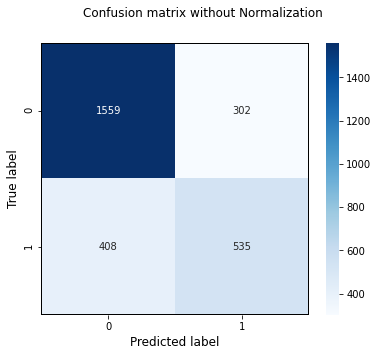

In [135]:
plot_confusion_matrix(y_test,predictions)

In [136]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

F2_Measure = (5 * precision * recall) / (4 * precision + recall)
F2_Measure

1.4103209756340078

In [137]:
y_act_test, predictions=get_predictions(dataset_test_iter, model_LSTM)   

In [138]:
predictions

array([1., 0., 1., ..., 1., 1., 1.])

In [139]:
predictions = np.append(predictions, 0)

In [140]:
df_test1['target']=predictions.astype(int)

In [141]:
df_test1['target'].value_counts()

0    2831
1    1063
Name: target, dtype: int64

In [142]:
df['labels'].value_counts()

0    6220
1    3126
Name: labels, dtype: int64

In [143]:
header = ["id", "target"]
df_test1.to_csv('submission4_1.csv', columns = header, index=False, encoding='utf-8')

**Bidirectional RNN**

In [144]:
n_vocab = len(TEXT.vocab)
embed_dim = 100
n_hidden = 150 
n_rnnlayers = 4
n_outputs = 2
bidirectional = True
dropout_rate = 0.01 

In [145]:
model_BI_RNN = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate=dropout_rate)
model_BI_RNN.to(device)

RNN(
  (embed): Embedding(10902, 100)
  (rnn): LSTM(100, 150, num_layers=4, batch_first=True, dropout=0.01, bidirectional=True)
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [146]:
for name, param in model_BI_RNN.named_parameters():
  print(name, param.shape)

embed.weight torch.Size([10902, 100])
rnn.weight_ih_l0 torch.Size([600, 100])
rnn.weight_hh_l0 torch.Size([600, 150])
rnn.bias_ih_l0 torch.Size([600])
rnn.bias_hh_l0 torch.Size([600])
rnn.weight_ih_l0_reverse torch.Size([600, 100])
rnn.weight_hh_l0_reverse torch.Size([600, 150])
rnn.bias_ih_l0_reverse torch.Size([600])
rnn.bias_hh_l0_reverse torch.Size([600])
rnn.weight_ih_l1 torch.Size([600, 300])
rnn.weight_hh_l1 torch.Size([600, 150])
rnn.bias_ih_l1 torch.Size([600])
rnn.bias_hh_l1 torch.Size([600])
rnn.weight_ih_l1_reverse torch.Size([600, 300])
rnn.weight_hh_l1_reverse torch.Size([600, 150])
rnn.bias_ih_l1_reverse torch.Size([600])
rnn.bias_hh_l1_reverse torch.Size([600])
rnn.weight_ih_l2 torch.Size([600, 300])
rnn.weight_hh_l2 torch.Size([600, 150])
rnn.bias_ih_l2 torch.Size([600])
rnn.bias_hh_l2 torch.Size([600])
rnn.weight_ih_l2_reverse torch.Size([600, 300])
rnn.weight_hh_l2_reverse torch.Size([600, 150])
rnn.bias_ih_l2_reverse torch.Size([600])
rnn.bias_hh_l2_reverse torch.Si

In [147]:
model_BI_RNN.embed.weight.data.copy_(pretrained_embeddings)   #Initializing weights with Pre-trained embeddings

tensor([[ 4.7293e-02,  2.4148e+00, -3.7467e-01,  ..., -5.6043e-01,
         -4.2474e-01, -6.4430e-01],
        [-2.1092e-03,  1.1528e+00, -6.3001e-01,  ..., -1.2343e+00,
          6.8661e-01, -2.0555e-01],
        [ 3.1810e-01,  1.0088e+00, -2.6260e-01,  ..., -1.6182e-02,
          1.8295e+00, -5.7388e-01],
        ...,
        [-2.7968e-01,  1.0566e+00,  3.9891e-01,  ..., -5.3530e-01,
          7.4959e-01,  1.0814e+00],
        [-1.2533e-01, -3.7238e-01, -5.5980e-02,  ...,  3.3211e-01,
         -4.0862e-01, -2.7781e-01],
        [-5.5559e-01, -1.7610e-02,  6.5311e-01,  ...,  2.4946e-01,
         -7.5647e-02,  6.6210e-02]], device='cuda:0')

In [148]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model_BI_RNN.embed.weight.data[unk_idx] = torch.zeros(embed_dim)
model_BI_RNN.embed.weight.data[pad_idx] = torch.zeros(embed_dim)

print(model_BI_RNN.embed.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3181,  1.0088, -0.2626,  ..., -0.0162,  1.8295, -0.5739],
        ...,
        [-0.2797,  1.0566,  0.3989,  ..., -0.5353,  0.7496,  1.0814],
        [-0.1253, -0.3724, -0.0560,  ...,  0.3321, -0.4086, -0.2778],
        [-0.5556, -0.0176,  0.6531,  ...,  0.2495, -0.0756,  0.0662]],
       device='cuda:0')


**Train Model**

In [149]:
learning_rate = 0.005
epochs=300

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model_BI_RNN.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [150]:
patience = 10
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0
path = folder / 'early_stop_nlp.pt'

# Freeze embedding Layer

#freeze embeddings
model_BI_RNN.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  scheduler.step()
  t0= datetime.now()
  train_loss=[]
  
  model_BI_RNN.train()
  
  for batch in train_iter:
    # forward pass
    output= model_BI_RNN(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model_BI_RNN.eval()
  with torch.no_grad():
    for batch in valid_iter:
 
      # forward pass
      output= model_BI_RNN(batch.data)
      loss=criterion(output,batch.label)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')


   ## Early Stopping
  ##==================
    
  score = -valid_loss
  print("Validation loss is {0} and score is {1} ".format(valid_loss, score))

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_BI_RNN.state_dict(), path)
      valid_loss_min = valid_loss
      
  elif score < best_score + delta:
      counter_early_stop += 1

      print("Inside elif: Score is {0}, Best score is {1} and delta is {2} ".format(score, best_score, delta))

      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      
      if counter_early_stop >= patience:
          early_stop = True
          # un-freeze embeddings - start updating weights when validation losses start to increase
          #========================================================================================
          model_BI_RNN.embed.weight.requires_grad  = True

  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_BI_RNN.state_dict(), path)
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/300, Train Loss: 0.6052    Valid Loss: 0.5159, Duration: 0:00:03.156503
Validation loss is 0.5158927328884602 and score is -0.5158927328884602 
Validation loss decreased (inf --> 0.515893).  Saving model ...
Epoch 2/300, Train Loss: 0.5015    Valid Loss: 0.4887, Duration: 0:00:03.050250
Validation loss is 0.48868346586823463 and score is -0.48868346586823463 
Validation loss decreased (0.515893 --> 0.488683).  Saving model ...
Epoch 3/300, Train Loss: 0.4596    Valid Loss: 0.4856, Duration: 0:00:03.083491
Validation loss is 0.48560722917318344 and score is -0.48560722917318344 
Validation loss decreased (0.488683 --> 0.485607).  Saving model ...
Epoch 4/300, Train Loss: 0.4212    Valid Loss: 0.5206, Duration: 0:00:03.241860
Validation loss is 0.5206015165895224 and score is -0.5206015165895224 
Inside elif: Score is -0.5206015165895224, Best score is -0.48560722917318344 and delta is 0 
Early Stopping counter: 1 out of 10
Epoch 5/300, Train Loss: 0.3218    Valid Loss: 0.5376, D

In [151]:
train_acc = get_accuracy(train_iter, model_BI_RNN)
valid_acc = get_accuracy(valid_iter, model_BI_RNN)
test_acc = get_accuracy(test_iter ,model_BI_RNN)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.9696,	 Valid acc: 0.7667,	 Test acc: 0.7422


In [152]:
y_test, predictions=get_predictions(test_iter, model_BI_RNN)

In [153]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[1613,  248],
       [ 475,  468]])

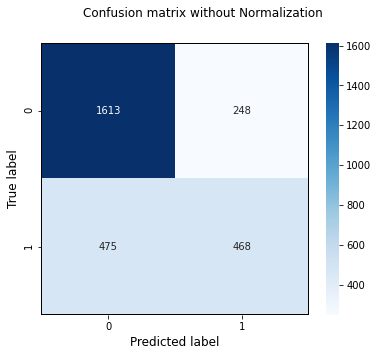

In [154]:
plot_confusion_matrix(y_test,predictions)

In [155]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

In [156]:
F2_Measure = (5 * precision * recall) / (4 * precision + recall)
F2_Measure

1.375198684818124

In [157]:
y_act_test, predictions=get_predictions(dataset_test_iter, model_BI_RNN)   

In [158]:
y_act_test

array([1., 1., 1., ..., 1., 1., 1.])

In [159]:
predictions

array([0., 0., 0., ..., 0., 0., 1.])

In [160]:
predictions = np.append(predictions, 0)

In [161]:
df_test1.head()

,id,data,target
0,90194,go home youre drunk maga trump url,1
1,77444,oh noes tough shit,0
2,13384,canada doesnt need another cuck already enough...,1
3,54920,scare every american playing hockey warped puck,0
4,56117,lol throwing bullshit flag nonsense putuporshu...,0


In [162]:
df_test1['target']=predictions.astype(int)

In [163]:
df_test1['target'].value_counts()

0    2880
1    1014
Name: target, dtype: int64

In [164]:
df['labels'].value_counts()

0    6220
1    3126
Name: labels, dtype: int64

In [165]:
df_test1.head()

,id,data,target
0,90194,go home youre drunk maga trump url,0
1,77444,oh noes tough shit,0
2,13384,canada doesnt need another cuck already enough...,0
3,54920,scare every american playing hockey warped puck,0
4,56117,lol throwing bullshit flag nonsense putuporshu...,0


In [166]:
header = ["id", "target"]
df_test1.to_csv('submission4-2.csv', columns = header, index=False, encoding='utf-8')

# CNN 

In [167]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):        
        super().__init__()                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes                                    
                                    ])        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)        
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):        
        emb = self.embedding(text).unsqueeze(1)        
        conved = [F.relu(c(emb)).squeeze(3) for c in self.convs]                
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]        
        concat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(concat)

In [168]:
input_dimensions = len(TEXT.vocab)
output_dimensions = 2
embed_dim = 100
number_of_filters = 80
filter_sizes = [1,2]
dropout_rate = 0.01

unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model_CNN = CNN(input_dimensions, embed_dim, number_of_filters, filter_sizes, output_dimensions, dropout_rate, pad_idx)


In [169]:
model_CNN.to(device)

CNN(
  (embedding): Embedding(10902, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 80, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 80, kernel_size=(2, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=160, out_features=2, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [170]:
for name, param in model_CNN.named_parameters():
  print(name, param.shape)

embedding.weight torch.Size([10902, 100])
convs.0.weight torch.Size([80, 1, 1, 100])
convs.0.bias torch.Size([80])
convs.1.weight torch.Size([80, 1, 2, 100])
convs.1.bias torch.Size([80])
fc.weight torch.Size([2, 160])
fc.bias torch.Size([2])


In [171]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([10902, 100])


In [172]:
model_CNN.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 4.7293e-02,  2.4148e+00, -3.7467e-01,  ..., -5.6043e-01,
         -4.2474e-01, -6.4430e-01],
        [-2.1092e-03,  1.1528e+00, -6.3001e-01,  ..., -1.2343e+00,
          6.8661e-01, -2.0555e-01],
        [ 3.1810e-01,  1.0088e+00, -2.6260e-01,  ..., -1.6182e-02,
          1.8295e+00, -5.7388e-01],
        ...,
        [-2.7968e-01,  1.0566e+00,  3.9891e-01,  ..., -5.3530e-01,
          7.4959e-01,  1.0814e+00],
        [-1.2533e-01, -3.7238e-01, -5.5980e-02,  ...,  3.3211e-01,
         -4.0862e-01, -2.7781e-01],
        [-5.5559e-01, -1.7610e-02,  6.5311e-01,  ...,  2.4946e-01,
         -7.5647e-02,  6.6210e-02]], device='cuda:0')

In [173]:
model_CNN.embedding.weight.data[unk_idx] = torch.zeros(embed_dim)
model_CNN.embedding.weight.data[pad_idx] = torch.zeros(embed_dim)

print(model_CNN.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3181,  1.0088, -0.2626,  ..., -0.0162,  1.8295, -0.5739],
        ...,
        [-0.2797,  1.0566,  0.3989,  ..., -0.5353,  0.7496,  1.0814],
        [-0.1253, -0.3724, -0.0560,  ...,  0.3321, -0.4086, -0.2778],
        [-0.5556, -0.0176,  0.6531,  ...,  0.2495, -0.0756,  0.0662]],
       device='cuda:0')


**Train Model**

In [174]:
learning_rate = 0.005
epochs=300

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [175]:
patience = 10
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0
path = folder / 'early_stop_nlp.pt'

# Freeze embedding Layer

#freeze embeddings
#model_CNN.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)

for epoch in range(epochs):
  scheduler.step()
  t0= datetime.now()
  train_loss=[]
  
  model_CNN.train()
  for batch in train_iter:
   
    # forward pass
    output= model_CNN(batch.data)    
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model_CNN.eval()

  with torch.no_grad():
    for batch in valid_iter:
       # forward pass
      output= model_CNN(batch.data)
      loss=criterion(output,batch.label)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

   ## Early Stopping
  ##==================
    
  score = -valid_loss
  print("Validation loss is {0} and score is {1} ".format(valid_loss, score))

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_CNN.state_dict(), path)
      valid_loss_min = valid_loss
      
  elif score < best_score + delta:
      counter_early_stop += 1

      print("Inside elif: Score is {0}, Best score is {1} and delta is {2} ".format(score, best_score, delta))

      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      
      if counter_early_stop >= patience:
          early_stop = True
          # un-freeze embeddings - start updating weights when validation losses start to increase
          #========================================================================================
          #model_CNN.embed.weight.requires_grad  = True

  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model_CNN.state_dict(), path)
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/300, Train Loss: 0.5566    Valid Loss: 0.5152, Duration: 0:00:00.648808
Validation loss is 0.5151609741151333 and score is -0.5151609741151333 
Validation loss decreased (inf --> 0.515161).  Saving model ...
Epoch 2/300, Train Loss: 0.3344    Valid Loss: 0.5477, Duration: 0:00:00.538800
Validation loss is 0.5477071702480316 and score is -0.5477071702480316 
Inside elif: Score is -0.5477071702480316, Best score is -0.5151609741151333 and delta is 0 
Early Stopping counter: 1 out of 10
Epoch 3/300, Train Loss: 0.1353    Valid Loss: 0.7444, Duration: 0:00:00.535001
Validation loss is 0.7444404680281878 and score is -0.7444404680281878 
Inside elif: Score is -0.7444404680281878, Best score is -0.5151609741151333 and delta is 0 
Early Stopping counter: 2 out of 10
Epoch 4/300, Train Loss: 0.0464    Valid Loss: 0.9790, Duration: 0:00:00.540275
Validation loss is 0.9789819978177547 and score is -0.9789819978177547 
Inside elif: Score is -0.9789819978177547, Best score is -0.5151609741

In [176]:
train_acc = get_accuracy(train_iter, model_CNN)
valid_acc = get_accuracy(valid_iter, model_CNN)
test_acc = get_accuracy(test_iter ,model_CNN)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.9985,	 Valid acc: 0.7458,	 Test acc: 0.7290


In [177]:
y_test, predictions=get_predictions(test_iter, model_CNN)

In [178]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[1537,  324],
       [ 436,  507]])

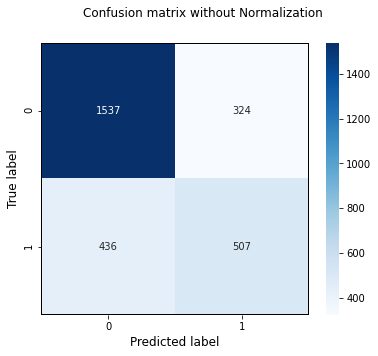

In [179]:
plot_confusion_matrix(y_test,predictions)

In [180]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

In [181]:
F2_Measure = (5 * precision * recall) / (4 * precision + recall)
F2_Measure

1.368586057409683

In [182]:
y_act_test, predictions=get_predictions(dataset_test_iter, model_CNN)   

In [183]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [184]:
predictions = np.append(predictions, 0)

In [185]:
df_test1['target']=predictions.astype(int)

In [186]:
df_test1['target'].value_counts()

0    2824
1    1070
Name: target, dtype: int64

In [187]:
header = ["id", "target"]
df_test1.to_csv('submission3.csv', columns = header, index=False, encoding='utf-8')